The data source is a Garmin Bike Computer   

The transformation related to time are
* adding timezone data to source data
* converting times to Dublin Time Zone
* producing a true time series with constant time interval of 1 second

## Setups

In [38]:
#Import Python Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree 
from datetime import datetime, timedelta
import os
import json
import pandas as pd
import numpy as np
from pytz import common_timezones, all_timezones, timezone

In [39]:
# Define name and path of data file
# This data file contains a sub-set of activiy information relating to speed and time

input_file = 'activity_input.csv'
input_dir = os.path.join("/", "opt","jupyter","data","csv" )
input_file_path = os.path.join(input_dir , input_file)

output_file = 'activity_speed_ts.csv'
output_dir = os.path.join("/", "opt","jupyter","data","csv" )
output_file_path = os.path.join(input_dir , output_file)



print ("Input file is (full path)  ", input_file_path)
print ("Output file is (full path)  ", output_file_path)

Input file is (full path)   /opt/jupyter/data/csv/activity_input.csv
Output file is (full path)   /opt/jupyter/data/csv/activity_speed_ts.csv


In [87]:
# Load data file into a Pandas data frame for inspection
# The dataframe is indexed on time - time variant data
df = pd.read_csv(input_file_path, index_col = 'time',  parse_dates=True)



# rename the speed column to speed_raw
#df.rename( columns = {"speed":"speed_raw"} , inplace=True)
#check column names
#df.columns

In [88]:
del df['Unnamed: 0']

In [89]:
df.columns

Index(['altitude', 'cadence', 'distance', 'heart_rate', 'latitude',
       'longitude'],
      dtype='object')

In [92]:
df.dtypes

altitude      float64
cadence       float64
distance      float64
heart_rate      int64
latitude      float64
longitude     float64
dtype: object

In [43]:
df.head()

altitude  cadence   distance  heart_rate   latitude  \
time                                                                        
2015-09-13 06:25:51  79.400002       76   5.010000         103  53.363708   
2015-09-13 06:25:56  90.800003       83  28.090000         106  53.363761   
2015-09-13 06:25:57  90.800003       84  34.740002         106  53.363779   
2015-09-13 06:26:00  90.800003       85  40.650002         108  53.363817   
2015-09-13 06:26:03  90.800003       87  52.090000         110  53.363877   

                     longitude  
time                            
2015-09-13 06:25:51  -6.190183  
2015-09-13 06:25:56  -6.190519  
2015-09-13 06:25:57  -6.190614  
2015-09-13 06:26:00  -6.190668  
2015-09-13 06:26:03  -6.190771

## Add Time Zone Data
The time data loaded from csv file does not contain TZ data.   
Actual data from Garmin is UTC.
So first need to label the data as UTC and the convert to Ireland Time Zone

In [44]:
# Define timezone of source data
tz_source = 'UTC'
# Set source timezone data
df = df.tz_localize( tz_source )

In [45]:
df.head()

altitude  cadence   distance  heart_rate  \
time                                                                   
2015-09-13 06:25:51+00:00  79.400002       76   5.010000         103   
2015-09-13 06:25:56+00:00  90.800003       83  28.090000         106   
2015-09-13 06:25:57+00:00  90.800003       84  34.740002         106   
2015-09-13 06:26:00+00:00  90.800003       85  40.650002         108   
2015-09-13 06:26:03+00:00  90.800003       87  52.090000         110   

                            latitude  longitude  
time                                             
2015-09-13 06:25:51+00:00  53.363708  -6.190183  
2015-09-13 06:25:56+00:00  53.363761  -6.190519  
2015-09-13 06:25:57+00:00  53.363779  -6.190614  
2015-09-13 06:26:00+00:00  53.363817  -6.190668  
2015-09-13 06:26:03+00:00  53.363877  -6.190771

In [46]:
# Define target time_zone
tz_local = timezone('Europe/Dublin')
# Convert data frame to desired Time Zone
df = df.tz_convert(tz_local  )
df.head()

altitude  cadence   distance  heart_rate  \
time                                                                   
2015-09-13 07:25:51+01:00  79.400002       76   5.010000         103   
2015-09-13 07:25:56+01:00  90.800003       83  28.090000         106   
2015-09-13 07:25:57+01:00  90.800003       84  34.740002         106   
2015-09-13 07:26:00+01:00  90.800003       85  40.650002         108   
2015-09-13 07:26:03+01:00  90.800003       87  52.090000         110   

                            latitude  longitude  
time                                             
2015-09-13 07:25:51+01:00  53.363708  -6.190183  
2015-09-13 07:25:56+01:00  53.363761  -6.190519  
2015-09-13 07:25:57+01:00  53.363779  -6.190614  
2015-09-13 07:26:00+01:00  53.363817  -6.190668  
2015-09-13 07:26:03+01:00  53.363877  -6.190771

## Exploring the Imported Data Set

The fitness data consists of a set of data points whose values vary in time.
The data is a sequence in time order.

Each data point relates to a different point in time and contains the following variables:
* distince_diff - the distance travelled since the last data point
* time_diff - the number of seconds that have elapsed since the last data point
* speed_raw - measured in km/hr, calculated using formula (distance_diff / time_diff) * 3.6
* moving - if the data point represents movement then True.  If the user is at rest then False
* breaks - Set to True if the using is at rest and taking a break from activity

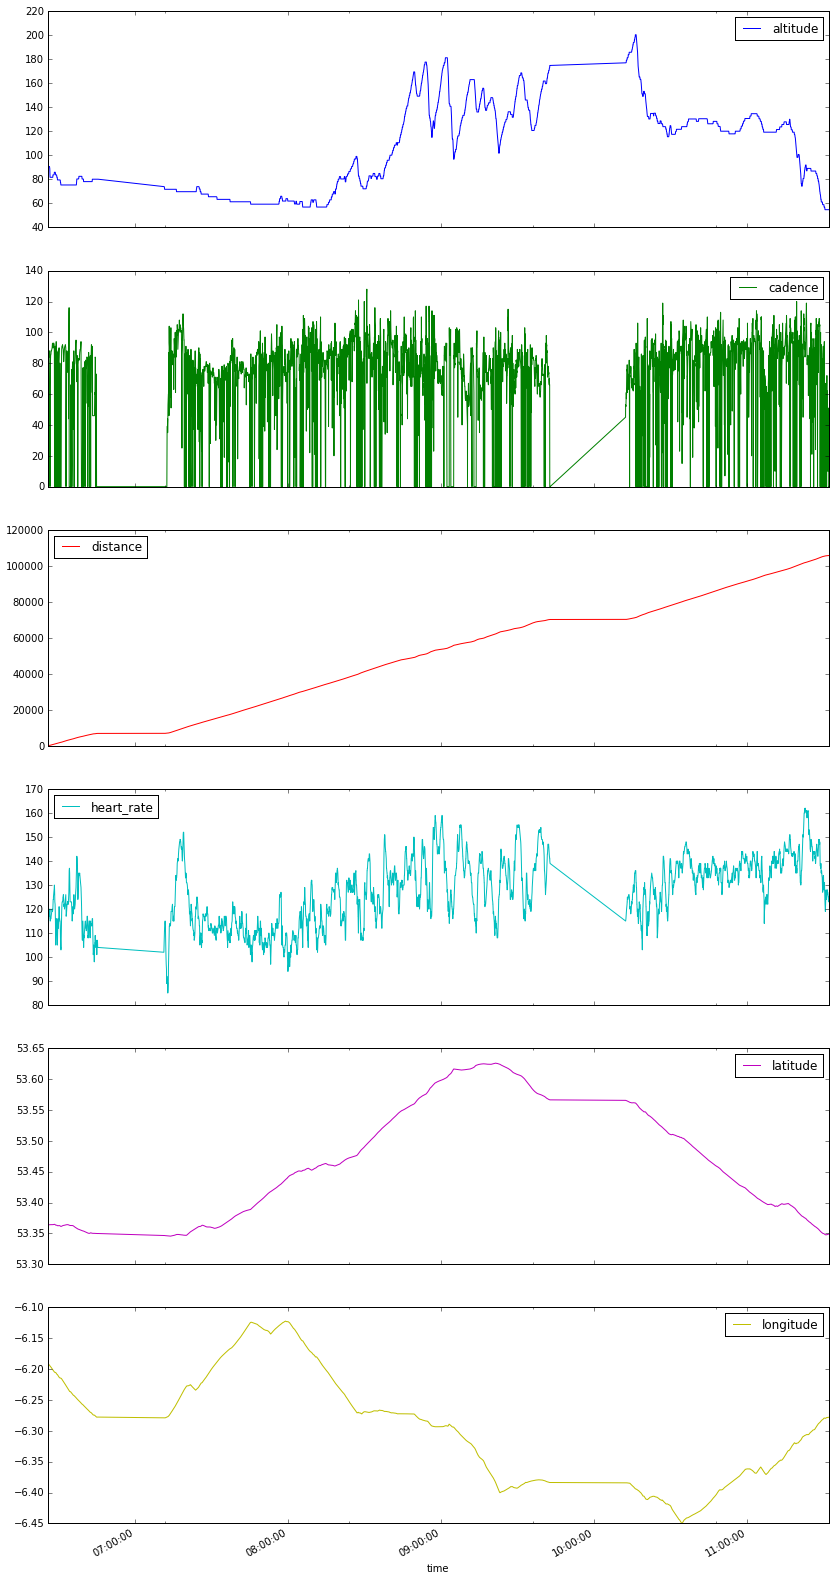

In [66]:
#plot all columns
_ = df.plot(
       subplots=True, 
        figsize=(14, 30),
         
        )

In [48]:
# get statistical summary
df.describe()

altitude      cadence       distance   heart_rate     latitude  \
count  5358.000000  5358.000000    5358.000000  5358.000000  5358.000000   
mean    111.955730    65.071482   55287.854537   128.561590    53.491467   
std      36.721701    35.185950   28136.527045    13.721647     0.093901   
min      54.799999     0.000000       5.010000    85.000000    53.345526   
25%      78.000000    55.000000   35433.338867   118.000000    53.397356   
50%     119.400002    78.000000   56190.744141   129.000000    53.495447   
75%     137.800003    89.000000   74210.966797   139.000000    53.577132   
max     200.600006   128.000000  105730.960938   162.000000    53.625859   

         longitude  
count  5358.000000  
mean     -6.301870  
std       0.083469  
min      -6.449606  
25%      -6.381121  
50%      -6.293265  
75%      -6.258252  
max      -6.122161

## Exploring the Time Interval between Data Points

Inspection of the first few rows shows that the data is time indexed.   
The time_diff column shows that the intervals between data points are whole seconds.    
The time interval between data points is not fixed - irregular interval between data points
For example there are 5 seconds between first and second data points.

### Time Difference Calculations

In [69]:
# based on index work out time difference in seconds
# default missing time difference (expecially first position) to 1 second
df['time_diff'] = df.index.to_series().diff().fillna(1).apply( lambda x: int( x / np.timedelta64(1, 's') ) )
df.describe()

altitude      cadence       distance   heart_rate     latitude  \
count  5358.000000  5358.000000    5358.000000  5358.000000  5358.000000   
mean    111.955730    65.071482   55287.854537   128.561590    53.491467   
std      36.721701    35.185950   28136.527045    13.721647     0.093901   
min      54.799999     0.000000       5.010000    85.000000    53.345526   
25%      78.000000    55.000000   35433.338867   118.000000    53.397356   
50%     119.400002    78.000000   56190.744141   129.000000    53.495447   
75%     137.800003    89.000000   74210.966797   139.000000    53.577132   
max     200.600006   128.000000  105730.960938   162.000000    53.625859   

         longitude    time_diff  
count  5358.000000  5358.000000  
mean     -6.301870     3.428891  
std       0.083469    32.195810  
min      -6.449606     1.000000  
25%      -6.381121     1.000000  
50%      -6.293265     1.000000  
75%      -6.258252     4.000000  
max      -6.122161  1775.000000

In [70]:
# view first few rows 
df.head()

altitude  cadence   distance  heart_rate   latitude  \
time                                                                        
2015-09-13 06:25:51  79.400002       76   5.010000         103  53.363708   
2015-09-13 06:25:56  90.800003       83  28.090000         106  53.363761   
2015-09-13 06:25:57  90.800003       84  34.740002         106  53.363779   
2015-09-13 06:26:00  90.800003       85  40.650002         108  53.363817   
2015-09-13 06:26:03  90.800003       87  52.090000         110  53.363877   

                     longitude  time_diff  
time                                       
2015-09-13 06:25:51  -6.190183          1  
2015-09-13 06:25:56  -6.190519          5  
2015-09-13 06:25:57  -6.190614          1  
2015-09-13 06:26:00  -6.190668          3  
2015-09-13 06:26:03  -6.190771          3

The histogram below shows that most common time interval between data points is 1 second. However many data points have multiple seconds between data points.

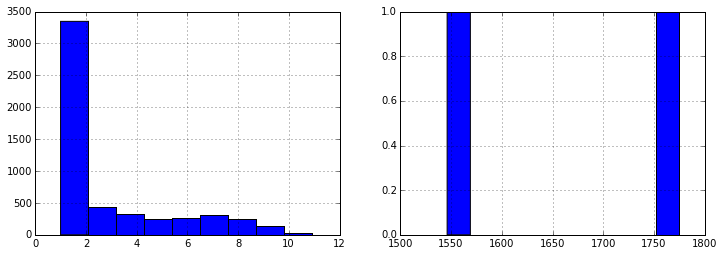

In [51]:
# plotting the time interval betwe

plt.figure() 
plt.subplot(1,2,1)
_ = df['time_diff'][df['time_diff'] < 600].hist(figsize=(12,4))
plt.subplot(1,2,2)
_ = df['time_diff'][df['time_diff'] > 600].hist(figsize=(12,4))

## Add a breaks columns
note ths column is call breaks because break is a Python keyword

In [71]:
df['breaks'] = (df['time_diff'] > 600)
df[ (df['time_diff'] > 100) ]

altitude  cadence      distance  heart_rate   latitude  \
time                                                                            
2015-09-13 07:11:26   74.000000        0   6910.580078         102  53.346748   
2015-09-13 10:12:23  177.199997       45  70205.281250         115  53.565620   

                     longitude  time_diff breaks  
time                                              
2015-09-13 07:11:26  -6.278896       1546   True  
2015-09-13 10:12:23  -6.384032       1775   True

## Transforming the Data Set to a Time Series
In this section a new dataframs is constructed with a constant frequency of 1 second.   
In the new dataframe there is exactly 1 second between all data points.
There are no missing data points - a row is generated for every second from start to end time

In [62]:
# create a new dataframe from original dataframe with a constant frequency of one second
time_series = df.asfreq(freq='S', )
time_series.head(10)

altitude  cadence   distance  heart_rate  \
time                                                                   
2015-09-13 07:25:51+01:00  79.400002       76   5.010000         103   
2015-09-13 07:25:52+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:53+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:54+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:55+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:56+01:00  90.800003       83  28.090000         106   
2015-09-13 07:25:57+01:00  90.800003       84  34.740002         106   
2015-09-13 07:25:58+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:59+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:26:00+01:00  90.800003       85  40.650002         108   

                            latitude  longitude  time_diff breaks  
time                                                               
2015-09-13 07:25:51+01:00  53.363708  -6.190183          1  False  
2015-09-13 07:25:52+01:00        NaN        NaN        NaN    NaN  
2015-09-13 07:25:53+01:00        NaN        NaN        NaN    NaN  
2015-09-13 07:25:54+01:00        NaN        NaN        NaN    NaN  
2015-09-13 07:25:55+01:00        NaN        NaN        NaN    NaN  
2015-09-13 07:25:56+01:00  53.363761  -6.190519          5  False  
2015-09-13 07:25:57+01:00  53.363779  -6.190614          1  False  
2015-09-13 07:25:58+01:00        NaN        NaN        NaN    NaN  
2015-09-13 07:25:59+01:00        NaN        NaN        NaN    NaN  
2015-09-13 07:26:00+01:00  53.363817  -6.190668          3  False

In [55]:
#time_series['speed_raw_ts'] = float(0)
time_series['distance_ts'] = float(0)

In [72]:
#time_series.moving.fillna(method = 'bfill', inplace=True)
time_series.breaks.fillna(method = 'bfill', inplace=True)
time_series.time_diff.fillna(0, inplace=True)


In [73]:
time_series.head(10)

altitude  cadence   distance  heart_rate  \
time                                                                   
2015-09-13 07:25:51+01:00  79.400002       76   5.010000         103   
2015-09-13 07:25:52+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:53+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:54+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:55+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:56+01:00  90.800003       83  28.090000         106   
2015-09-13 07:25:57+01:00  90.800003       84  34.740002         106   
2015-09-13 07:25:58+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:25:59+01:00        NaN      NaN        NaN         NaN   
2015-09-13 07:26:00+01:00  90.800003       85  40.650002         108   

                            latitude  longitude  time_diff breaks  
time                                                               
2015-09-13 07:25:51+01:00  53.363708  -6.190183          1  False  
2015-09-13 07:25:52+01:00        NaN        NaN          0  False  
2015-09-13 07:25:53+01:00        NaN        NaN          0  False  
2015-09-13 07:25:54+01:00        NaN        NaN          0  False  
2015-09-13 07:25:55+01:00        NaN        NaN          0  False  
2015-09-13 07:25:56+01:00  53.363761  -6.190519          5  False  
2015-09-13 07:25:57+01:00  53.363779  -6.190614          1  False  
2015-09-13 07:25:58+01:00        NaN        NaN          0  False  
2015-09-13 07:25:59+01:00        NaN        NaN          0  False  
2015-09-13 07:26:00+01:00  53.363817  -6.190668          3  False

In [75]:
time_series.interpolate(inplace=True)

In [93]:
time_series.head(10)

altitude    cadence   distance  heart_rate  \
time                                                                     
2015-09-13 07:25:51+01:00  79.400002  76.000000   5.010000  103.000000   
2015-09-13 07:25:52+01:00  81.680002  77.400000   9.626000  103.600000   
2015-09-13 07:25:53+01:00  83.960002  78.800000  14.242000  104.200000   
2015-09-13 07:25:54+01:00  86.240002  80.200000  18.858000  104.800000   
2015-09-13 07:25:55+01:00  88.520003  81.600000  23.474000  105.400000   
2015-09-13 07:25:56+01:00  90.800003  83.000000  28.090000  106.000000   
2015-09-13 07:25:57+01:00  90.800003  84.000000  34.740002  106.000000   
2015-09-13 07:25:58+01:00  90.800003  84.333333  36.710002  106.666667   
2015-09-13 07:25:59+01:00  90.800003  84.666667  38.680002  107.333333   
2015-09-13 07:26:00+01:00  90.800003  85.000000  40.650002  108.000000   

                            latitude  longitude  time_diff breaks  
time                                                               
2015-09-13 07:25:51+01:00  53.363708  -6.190183          1  False  
2015-09-13 07:25:52+01:00  53.363718  -6.190250          0  False  
2015-09-13 07:25:53+01:00  53.363729  -6.190317          0  False  
2015-09-13 07:25:54+01:00  53.363740  -6.190384          0  False  
2015-09-13 07:25:55+01:00  53.363750  -6.190451          0  False  
2015-09-13 07:25:56+01:00  53.363761  -6.190519          5  False  
2015-09-13 07:25:57+01:00  53.363779  -6.190614          1  False  
2015-09-13 07:25:58+01:00  53.363792  -6.190632          0  False  
2015-09-13 07:25:59+01:00  53.363804  -6.190650          0  False  
2015-09-13 07:26:00+01:00  53.363817  -6.190668          3  False

In [99]:
time_series.cadence = time_series.cadence.round().astype('int')
time_series.heart_rate = time_series.heart_rate.round().astype('int')

In [100]:
time_series.dtypes

altitude      float64
cadence         int64
distance      float64
heart_rate      int64
latitude      float64
longitude     float64
time_diff     float64
breaks           bool
dtype: object

In [101]:
time_series.head(10)

altitude  cadence   distance  heart_rate  \
time                                                                   
2015-09-13 07:25:51+01:00  79.400002       76   5.010000         103   
2015-09-13 07:25:52+01:00  81.680002       77   9.626000         104   
2015-09-13 07:25:53+01:00  83.960002       78  14.242000         104   
2015-09-13 07:25:54+01:00  86.240002       80  18.858000         105   
2015-09-13 07:25:55+01:00  88.520003       81  23.474000         105   
2015-09-13 07:25:56+01:00  90.800003       83  28.090000         106   
2015-09-13 07:25:57+01:00  90.800003       84  34.740002         106   
2015-09-13 07:25:58+01:00  90.800003       84  36.710002         107   
2015-09-13 07:25:59+01:00  90.800003       84  38.680002         107   
2015-09-13 07:26:00+01:00  90.800003       85  40.650002         108   

                            latitude  longitude  time_diff breaks  
time                                                               
2015-09-13 07:25:51+01:00  53.363708  -6.190183          1  False  
2015-09-13 07:25:52+01:00  53.363718  -6.190250          0  False  
2015-09-13 07:25:53+01:00  53.363729  -6.190317          0  False  
2015-09-13 07:25:54+01:00  53.363740  -6.190384          0  False  
2015-09-13 07:25:55+01:00  53.363750  -6.190451          0  False  
2015-09-13 07:25:56+01:00  53.363761  -6.190519          5  False  
2015-09-13 07:25:57+01:00  53.363779  -6.190614          1  False  
2015-09-13 07:25:58+01:00  53.363792  -6.190632          0  False  
2015-09-13 07:25:59+01:00  53.363804  -6.190650          0  False  
2015-09-13 07:26:00+01:00  53.363817  -6.190668          3  False

num_rows = len( time_series[ (time_series.time_diff.notnull() )] )
for i in range( num_rows ):
    row = time_series[ (time_series.time_diff.notnull() )].iloc[i] 
    row_time = row.name
    if row.breaks == False:
        start_time = row_time - timedelta(seconds = ( int(row.time_diff) - 1))
        new_dist = ( row.distance_diff / int(row.time_diff) ) 
        
        time_series[ start_time:row_time ].distance_ts = new_dist
        time_series[ start_time:row_time ].speed_raw_ts = new_dist * 3.6

In [34]:
num_rows = len( time_series[ (time_series.time_diff.notnull() )] )
for i in range( num_rows ):
    row = time_series[ (time_series.time_diff.notnull() )].iloc[i] 
    row_time = row.name
    if row.breaks == False:
        start_time = row_time - timedelta(seconds = ( int(row.time_diff) - 1))
        new_dist = ( row.distance_diff / int(row.time_diff) ) 
        
        time_series.loc[ start_time:row_time, 'distance_ts'] = new_dist

In [61]:
time_series.tail(10)

altitude  cadence       distance  heart_rate  \
time                                                                       
2015-09-13 12:31:53+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:31:54+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:31:55+01:00  54.799999        0  105728.062500         123   
2015-09-13 12:31:56+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:31:57+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:31:58+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:31:59+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:32:00+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:32:01+01:00        NaN      NaN            NaN         NaN   
2015-09-13 12:32:02+01:00  54.799999        0  105730.960938         125   

                            latitude  longitude  time_diff breaks  distance_ts  
time                                                                            
2015-09-13 12:31:53+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:31:54+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:31:55+01:00  53.348772  -6.277988          4  False            0  
2015-09-13 12:31:56+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:31:57+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:31:58+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:31:59+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:32:00+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:32:01+01:00        NaN        NaN        NaN  False            0  
2015-09-13 12:32:02+01:00  53.348787  -6.277960          7  False            0

#label the index, give it name 'time'
time_series.index.name = 'time'

In [36]:
time_series.to_csv(output_file_path)